Simply importing the needed classes.
Notice the AAAx and BBBx dicts are optimal guesses for a few Q curves as interpolated from our CDS bootstrapping class
This computation is expensive and does not always converge for our intial guess of x0Vas so I have copied them here to save some computations.


In [60]:
from pandas import DataFrame
import numpy as np
import pandas as pd
from datetime import date
import math
from dateutil.relativedelta import relativedelta
from random import shuffle
import random
import fractions

AAAx={'3M': [1.0015824271136229, 0.07118430651357378, -0.16068883479216692, 0.0073983085859183105, 3.1083459253964976, -4.971784090683851, -0.4774848528659512, -0.10058722679096088, -0.32595880089361595, 1.2498165670968577, 3.4947594489126534, 0.7693240320536217, 1.3561952580367567, 6.371501575362355, 1.5717830330107334, 3.0431872392927932], '6M': [0.6253740242837578, 0.07187788235360676, 0.002756754524306165, 0.0007534565001362353, -1.9788331302293565, 1.3633887485139464, 5.119926963331688, 3.1051517704782445, 0.7634682512381973, -0.2440315461962444, -1.625294304111004, 1.1807892914373608, 1.5803472042649411, 2.2546258881657137, -0.6220529111275982, -3.918280795179225], '1Y': [0.02268430209412819, 0.12335315163831377, 0.0019492996048123179, 0.001628657655447479, 2.012129584631548, -0.14425637029306565, 3.0201995002610156, 2.147972541679386, -0.5128642176120338, 2.2747902950169627, -0.20546619851504466, 1.5945520333717365, 1.1372771020777144, 3.5153776822797216, 0.9602982736891876, -2.470770239032655], '3Y': [26.4868013103451, 0.10123386920113561, 0.007172027822595987, -0.0011729920248976869, 4.671838150691669, 2.0943942967130518, 1.8784163354679428, 2.829205309274365, 0.6419078923238758, 1.9913439793507237, 0.9155288227819725, 0.2038138762167537, 5.345533516522538, 3.7619427230742546, 0.1152302416309914, 2.657152673978014]}
BBBx={'3M': [2.2676030271568077, 0.06869592728485677, -0.002415215219504258, 0.0010910153202821262, 2.076053981582788, -2.4830012835412374, 1.4792817746843325, 2.227857983492404, -0.3936126755070518, -0.16392645500488395, 1.285584627035015, 3.041436386446073, 3.2291187114730233, 3.3449348319234886, -2.054285553987237, 0.906769966943711]}
class MC_Vasicek_Sim(object):
    """ Monte Carlo simulator for interest rates under the Vasicek 
    model.

    Attributes
    ----------
    kappa (float): Vasicek perameter: 'speed of reversion'.
    theta (float): Vasicek perameter: 'long term mean level'.
    sigma (float): Vasicek perameter: 'volatility'
    r0 (float): Vasicek perameter: 'initial value'.
    t_step (float): The time difference between the 'steps' in the 
        simulation. Represents 'dt' in the Vasicek model. Should always
        be set to 1 day.
    simNumber (int): The number of times the simulation is to execute.
    datelist (list): A list of strings that are date-formatted (e.g.
        '2016-10-17').
    datelistlong (list): A list of days between (and including) 
        min(datelist) and max(datelist). Each element is of type 
        datetime.date.
    ntimes (list):  The length of datelistlong.
    libor (pandas DataFrame): A (1 + ntimes, simNumber) shaped array 
        that  contains the simulated discount curves. The zeroth column 
        contains the mean curve. The type of each element is 
        numpy.float64. The row labels are dates corresponding to
        nodes in the simulation.
    smallLibor (pandas DataFrame): A matrix subset of the 
        libor array. But it only contains rows corresponding to the 
        dates in `datelist` instead of `datelistlong`.
    liborAvg (numpy ndarray): A vector containing the mean
        simulated libor values. It is also the zeroth column of 
        `libor`.
    """
    def __init__(self, datelist,x, simNumber,t_step):

        """Perameters
        ----------
        datelist (list): A list of strimgs that are date-formatted,
            e.g. '2012-04-16'.
        x (tuple): A 4-tuple containing the Vasicek SDE perameters:
            kappa, theta, sigma, r0.
        simNumber (int): The number of simulations that is to be 
            executed.
        """
    #SDE parameters - Vasicek SDE
    # dr(t) = k(θ − r(t))dt + σdW(t)
        self.kappa = x[0]
        self.theta = x[1]
        self.sigma = x[2]
        self.r0 = x[3]
        self.simNumber = simNumber
        self.t_step = t_step
    #internal representation of times series - integer multiples of t_step
        self.datelist = datelist
    #creation of a fine grid for Monte Carlo integration
        #Create fine date grid for SDE integration
        minDay = min(datelist)
        maxDay = max(datelist)
        self.datelistlong = pd.date_range(minDay, maxDay).tolist()
        self.datelistlong = [x.date() for x in self.datelistlong]
        self.ntimes = len(self.datelistlong)
        self.libor=[]
        self.smallLibor = []
        self.liborAvg=pd.DataFrame()
        
    def getLibor(self):
        """Executes the simulations and returns the simulated libor curves.

        Returns
        -------
        A large 2D pandoc DataFrame. Each column represents a simulated value of
        the libor curve at a given point in time. Each row corresponds to a
        date in `datelonglist`. The zeroth column contains the mean value of
        the simulated libor curves. The row labels are the elements of 
        datelonglist.
        """

        rd = np.random.standard_normal((self.ntimes,self.simNumber))   # array of numbers for the number of samples
        r = np.zeros(np.shape(rd))
        nrows = np.shape(rd)[0]
        sigmaDT = self.sigma* np.sqrt(self.t_step)
        #calculate r(t)
        r[1,:] = self.r0+r[1,:]
        for i in np.arange(2,nrows):
            r[i,:] = r[i-1,:]+ self.kappa*(self.theta-r[i-1,:])*self.t_step + sigmaDT*rd[i,:]
        #calculate integral(r(s)ds)
        integralR = r.cumsum(axis=0)*self.t_step
        #calculate Libor
        self.libor = np.exp(-integralR)
        self.liborAvg=np.average(self.libor,axis=1)
        self.libor=np.c_[self.liborAvg,self.libor]
        self.libor = pd.DataFrame(self.libor,index=self.datelistlong)
        return self.libor

genUnderlyings generates a stripped down version of an underlying with the important information stored in a tuple.
The computation later gets very slow the larger the number of underlyings. 

In [61]:
def genUnderlyings(notional,R,start,freq,quality,number):
    out=[]
    for i in range(0,number):
        out.append((notional,start,freq,quality,R))
    
    return out

In [62]:
class Scheduler(object):
    def __init__(self):
        pass
    def extractDelay(self, freq):
        if type(freq) == list:
            freq = freq[0]
        if (freq == 'Date'): return relativedelta(days=+ 1)
        x = self.only_numerics(freq)
        if (x == ''):
            freqValue = 100
        else:
            freqValue = np.int(x)
        if (freq.upper().find('D') != -1): delta = relativedelta(days=+  freqValue)
        if (freq.upper().find('W') != -1): delta = relativedelta(weeks=+  freqValue)
        if (freq.find('M') != -1): delta = relativedelta(months=+ freqValue)
        if (freq.find('Y') != -1): delta = relativedelta(years=+ freqValue)
        if (freq.find('ZERO') != -1): delta = relativedelta(years=+ freqValue)
        return delta
    def only_numerics(self, seq):
        seq_type = type(seq)
        return seq_type().join(filter(seq_type.isdigit, seq))


The book calls this type of function an exact function. The underlying principle is that we can build the conditional loss distribution by remembering the fact that when the underlying credits are independent we have a natural recursive algorithim to calculate. Also notice, that for base cases if 0 credits default in a portfolio of 0 then the probability of this event is set to 1. In a portfolio of 0 credits and the probability of more than 1 default occuring is 0. 
Naturally, the probability that the portfolio survives is simply the multiplication of the underlying survival probabilities. So the rest is easily computed by recursion. 

In this function we used our Monte Carlo simulator to give us the Q(0,Maturity) for each of the underlyings. Then 
f(k,j) calculates the probability of k defaults in a portfolio of j credits under our homogenous loss. Although this is very easily extendable to inhomogenous cases as the book points out using a greatest common denomenator. 



In [81]:


class ExactFunc(object):
    
    def __init__(self,start,underlyings):
        
        myScheduler=Scheduler()
        myDelays=[]
        freqs=['3M','6M','1Y','3Y']
        for i in range(0,len(freqs)):
            myDelays.append(myScheduler.extractDelay(freqs[i]))
        AAA={}
        for i in range(0,len(freqs)):
            vas=MC_Vasicek_Sim(x=AAAx[freqs[i]],datelist=[start,myDelays[i]+start],t_step=1/365.,simNumber=500)
            AAA[freqs[i]]=vas.getLibor()[0].loc[myDelays[i]+start]
        
        BBB={'3M': MC_Vasicek_Sim(x=BBBx[freqs[0]],datelist=[start,myDelays[0]+start],t_step=1/365.,simNumber=500).getLibor()[0].loc[myDelays[0]+start]}
        self.probs={'AAA': AAA, 'BBB':BBB}
        self.underlyings=underlyings
        
    def f(self,k,j):
        ''' 
        The recursion relation for the homogenous portfolio 
        takes in k: an int for numer of defaults 
        and j: number of underlyings you want to consider in the calculation k cannnot be greater than j
        
        
        
        '''
        if(j==0 and k==0):
            return 1
        if(j==0 and k>0):
            return 0
        if(k==0 and j>0):
            return self.f(k,j-1)*self.probs[self.underlyings[j][3]][self.underlyings[j][2]]
        else:
            return self.f(k,j-1)*(self.probs[self.underlyings[j][3]][self.underlyings[j][2]])+self.f(k-1,j-1)*(1-self.probs[self.underlyings[j][3]][self.underlyings[j][2]])
    '''
    Helper functions 
    
    '''
    def gcd(self,x, y):
        while y != 0:
            (x, y) = (y, x % y)
        return x
        
    def totalGCD(self):
        g=(1-self.underlyings[0][4])*self.underlyings[0][0]
        for i in range(1,len(self.underlyings)):
            g=self.gcd(g,((1-self.underlyings[i][4])*self.underlyings[i][0]))
        return g

    def getLossVec(self):
        g=self.totalGCD()
        n=[]
        for i in range(0,len(self.underlyings)):
            n.append(((1-self.underlyings[i][4])*self.underlyings[i][0])/g)
        return n
    
    def fprime(self,k,j,vec):
        '''
        recursion relation for inhomogenous portfolio takes 
        k an int representing number of defaulted credits
        j an int representing number of underlyings we wish to consider
        vec a list of length of underlyings with the underlyings Loss given default scaled by gcd so
        each entry is an int
        '''
        if(j==0 and k==0):
            return 1
        if(j==0 and k>0):
            return 0
        if(0<k and vec[j]>k):
            return self.fprime(k,j-1,vec)*self.probs[self.underlyings[j][3]][self.underlyings[j][2]]
        if(vec[j]<= k and k<=np.array(vec[0:j]).sum()):
            return self.fprime(k,j-1,vec)*(self.probs[self.underlyings[j][3]][self.underlyings[j][2]])+self.fprime(k-vec[j],j-1,vec)*(1-self.probs[self.underlyings[j][3]][self.underlyings[j][2]])
        else:
            return self.fprime(k,j-1,vec)*self.probs[self.underlyings[j][3]][self.underlyings[j][2]]
'''
methods to get number of defaults required to break tranche upperstrike not used just informative



'''
    def getTrancheNumb(self,K):
        sum=np.array(self.getLossVec()).sum()
        losses=self.getLossVec()
        totalLoss=0
        for i in range(0,len(losses)):
            totalLoss=totalLoss+losses[i]/sum
            if(totalLoss >= K):
                return i

    def threshold(self,K):
        sum=np.array(self.getLossVec()).sum()
        return math.floor(sum*K)


In [82]:
trim_start=date(2005,1,10)

In [83]:
credits=genUnderlyings(1,.4,trim_start,'3M','AAA',10)+genUnderlyings(1,.4,trim_start,'6M','AAA',10)+genUnderlyings(1,.4,trim_start,'1Y','AAA',10)+genUnderlyings(1,.4,trim_start,'3Y','AAA',5)+genUnderlyings(1,.4,trim_start,'3M','BBB',5)



In [84]:

ex=ExactFunc(underlyings=credits,start=trim_start)


In [85]:
y=[]
x=[]
for i in range(0,7):
    y.append(ex.f(i,len(ex.underlyings)-1))
    x.append(i*.6)

<Container object of 7 artists>

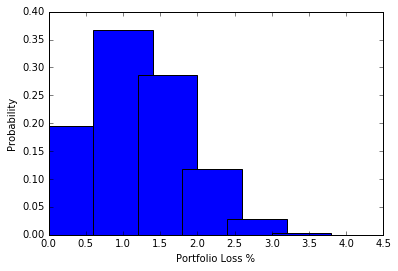

In [86]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.xlabel("Portfolio Loss %")
plt.ylabel("Probability")
plt.bar(x,y)

Here we are inserting a list of underlyings with a random recovery. After some expirementation the random recovery
can cause the sum of the losses of the credits to get extremely large. There is a discussion in the book about this issue. So we consider only a minimal case where a few credits have recovery different than .4. But now we will look at the loss in terms of "loss units." We create a method to determine the number of units lost out of the total will breach the upper strike. So we can limit our iterations of defaults to just these numbers. 


In [87]:
randR=genUnderlyings(100,.4,trim_start,'3M','AAA',20)+genUnderlyings(100,.4,trim_start,'6M','AAA',10)+genUnderlyings(100,.4,trim_start,'1Y','AAA',10)+genUnderlyings(100,round(random.uniform(.25,.5),2),trim_start,'3Y','AAA',1)+genUnderlyings(100,.3,trim_start,'3M','BBB',1)
shuffle(randR)


In [88]:
exactRandR=ExactFunc(underlyings=randR,start=trim_start)

In [100]:
z=[]
w=[]
for i in range(0,exactRandR.threshold(.1)):
    z.append(exactRandR.fprime(i,len(exactRandR.underlyings)-1,exactRandR.getLossVec()))
    w.append(i)

<Container object of 253 artists>

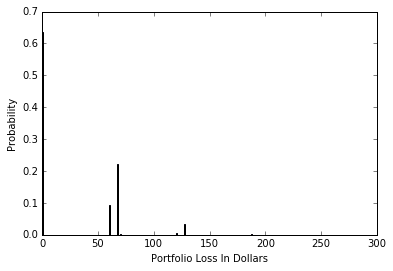

In [102]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.xlabel("Portfolio Loss In Dollars")
plt.ylabel("Probability")
plt.bar(w,z)